importing the required packages and libraries.

In [332]:
import os
import xml.etree.ElementTree as ET
import tensorflow as tf
import keras_cv
from tqdm.auto import tqdm
from tensorflow import keras
from keras_cv import bounding_box
from keras_cv import visualization
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.models import Sequential, model_from_json

Globale Variable

In [367]:
# Path
gv_path_models= "workspace/models/"
gv_path_images = "workspace/images/original_name/"
gv_annotation_path= "workspace/annotations/original/pascal/"
gv_model_path = "workspace/models/detector.h5"

SPLIT_RATIO = 0.2
BATCH_SIZE = 2
LEARNING_RATE = 0.001
EPOCH = 50
GLOBAL_CLIPNORM = 10.0

The Dataset Preparation

In [183]:
class_ids = [
"Ausbildung_Klasse" ,
"Ausbildung_Antrag_gestellt_ja" ,
"Ausbildung_Antrag_gestellt_nein" ,
"Ausbildung_Amt" ,
"Ausbildung_Foerderungsnummer" ,
"Ausbilung_Abschluss" ,
"Ausbildung_Vollzeit" ,
"Ausbildung" ,
"Ausbildung_Teilzeit" ,
"Ausbildung_Staette" ,
"Person" ,
"Person_Geburtsort" ,
"Person_maennlich" ,
"Person_Geburtsdatum" ,
"Person_weiblich",
"Person_divers",
"Person_Name",
"Person_Familienstand" ,
"Person_Vorname" ,
"Person_Geburtsname" ,
"Person_Familienstand_seit",
"Person_Stattsangehörigkeit_eigene" ,
"Person_Stattsangehörigkeit_Ehegatte" ,
"Person_Kinder",
"Wohnsitz_Strasse",
"Wohnsitz_Land",
"Wohnsitz_Postleitzahl",
"Wohnsitz",
"Wohnsitz_Hausnummer",
"Wohnsitz_Adresszusatz",
"Wohnsitz_Ort",
"Wohnsitz_waehrend_Ausbildung" ,
"Wohnsitz_waehrend_Ausbildung_Strasse",
"Wohnsitz_waehrend_Ausbildung_Hausnummer",
"Wohnsitz_waehrend_Ausbildung_Land",
"Wohnsitz_waehrend_Ausbildung_Ort",
"Wohnsitz_waehrend_Ausbildung_elternwohnung_nein",
"Wohnsitz_waehrend_Ausbildung_Adresszusatz",
"Wohnsitz_waehrend_Ausbildung_Postleitzahl",
"Wohnsitz_waehrend_Ausbildung_elternmiete",
"Wohnsitz_waehrend_Ausbildung_elternwohnung_ja",
"Wohnsitz_waehrend_Ausbildung_elternmiete_nein"
]

class_mapping = dict(zip(range(len(class_ids)), class_ids))

In [184]:
# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(gv_annotation_path, file_name)
        for file_name in os.listdir(gv_annotation_path)
        if file_name.endswith(".xml")
    ]
)
 
# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(gv_path_images, file_name)
        for file_name in os.listdir(gv_path_images)
        if file_name.endswith(".jpg")
    ]
)

parsing the XML annotation files

In [120]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
 
    image_name = root.find("filename").text
    image_path = os.path.join(gv_path_images, image_name)
 
    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)
 
        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        
        boxes.append([xmin, ymin, xmax, ymax])
 
    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids
 

In [121]:
image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

  0%|          | 0/16 [00:00<?, ?it/s]

Fläche der bbox wird gerechnet um herauszufinden, was sind die größte und kleinste bbox

In [122]:
f=[]
fleache = []
for b in bbox:
    f = []
    for i in b:
        w = i[2] - i[0]
        h = i[3] - i[1]
        A = w * h
        f.append(A)
    f.sort()    
    fleache.append(f)
print(fleache[0])    


[394.6634999999995, 406.38219999999745, 406.38220000000194, 406.58880000000056, 406.58880000000175, 415.4375000000002, 433.49999999999955, 433.49999999999955, 448.67249999999893, 448.67249999999893, 468.1800000000004, 471.85199999999867, 2184.5700000000024, 2314.1815999999985, 3221.5000000000005, 3393.4997999999973, 3394.6704000000027, 3439.2680000000037, 4530.074999999999, 5404.016099999987, 5673.069999999991, 6240.297799999996, 6591.680300000008, 9120.839999999991, 9236.439999999984, 9346.676499999994, 9452.883999999995, 9487.869999999995, 10377.718000000017, 10558.844100000004, 10606.896000000013, 11046.307399999996, 14003.844400000044, 14328.762000000012, 19517.719300000015, 20250.229999999967, 20798.559299999986, 20936.559599999982, 68041.09709999998, 104898.35480000002, 145991.23500000002]


In [185]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
 
    image_name = root.find("filename").text
    image_path = os.path.join(gv_path_images, image_name)
 
    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
 
        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        
        w = xmax - xmin
        h = ymax - ymin
        A = w * h
        
        if 2000 < A < 60000:
            classes.append(cls)
            boxes.append([xmin, ymin, xmax, ymax])
            
 
    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids

In [186]:
image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

  0%|          | 0/16 [00:00<?, ?it/s]

In [187]:
print(len(classes))
for i in range(len(classes)):
    print(len(classes[i]))

print(classes)

16
26
26
26
24
26
26
26
26
26
26
26
26
26
26
26
26
[[16, 18, 19, 11, 13, 17, 20, 21, 22, 24, 28, 29, 29, 26, 30, 32, 33, 37, 34, 38, 35, 3, 4, 9, 0, 5], [16, 18, 19, 11, 13, 17, 20, 21, 22, 24, 28, 29, 29, 26, 30, 32, 33, 37, 34, 38, 35, 3, 4, 9, 0, 5], [16, 18, 19, 11, 13, 17, 20, 21, 22, 24, 28, 29, 29, 26, 30, 32, 33, 37, 34, 38, 35, 3, 4, 9, 0, 5], [16, 18, 19, 11, 13, 17, 20, 21, 22, 24, 28, 29, 26, 30, 32, 33, 37, 38, 35, 3, 4, 9, 0, 5], [16, 18, 19, 11, 13, 17, 20, 21, 22, 24, 28, 29, 29, 26, 30, 32, 33, 37, 34, 38, 35, 3, 4, 9, 0, 5], [16, 18, 19, 11, 13, 17, 20, 21, 22, 24, 28, 29, 29, 26, 30, 32, 33, 37, 34, 38, 35, 3, 4, 9, 0, 5], [16, 18, 19, 11, 13, 17, 20, 21, 22, 24, 28, 29, 29, 26, 30, 32, 33, 37, 34, 38, 35, 3, 4, 9, 0, 5], [16, 18, 19, 11, 13, 17, 20, 21, 22, 24, 28, 29, 29, 26, 30, 32, 33, 37, 34, 38, 35, 3, 4, 9, 0, 5], [16, 18, 19, 11, 13, 17, 20, 21, 22, 24, 28, 29, 29, 26, 30, 32, 33, 37, 34, 38, 35, 3, 4, 9, 0, 5], [16, 18, 19, 11, 13, 17, 20, 21, 22, 24, 28, 29

In [188]:
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

#data = tf.data.Dataset.from_tensor_slices((image_paths, bbox))
data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

In [189]:
# Determine the number of validation samples
num_val = int(len(xml_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

In [190]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image
 

def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

In [376]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640),
            scale_factor=(0.75, 1.3),
            bounding_box_format="xyxy",
        ),
    ]
)

In [377]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 8)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

In [378]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 8)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

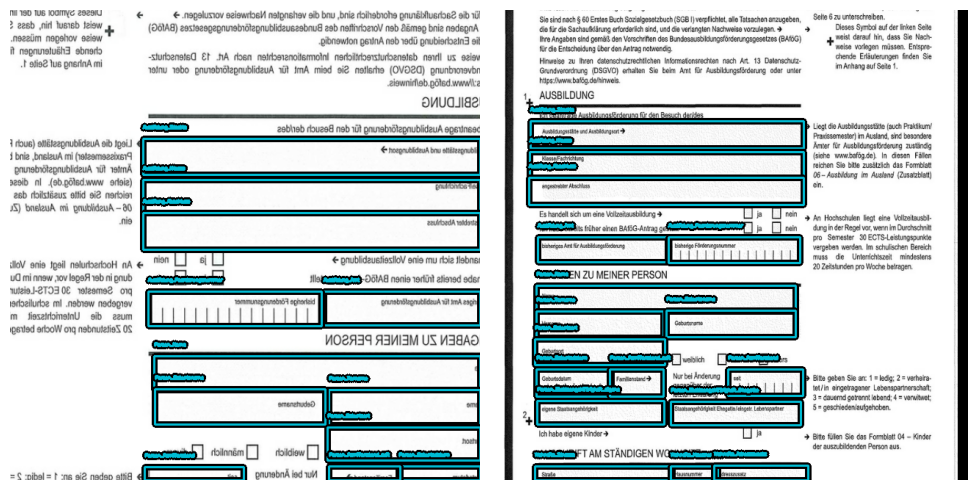

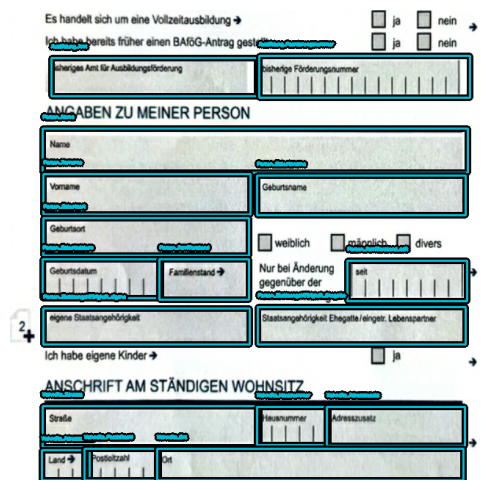

In [379]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.2,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )
 
 
visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=1, cols=2
)
 
visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=1, cols=1
)

In [380]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]
 
 
train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
 
val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [381]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
     # "yolo_v8_xs_backbone"
    "yolo_v8_xs_backbone_coco",
    # "yolo_v8_m_backbone"
     load_weights=True #It is important to set the load_weights = True, else 
                        # the COCO pretrained weights will not get loaded into the backbone
)
 
yolo_coco = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping), #the number of object classes
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)
 
#yolo.summary()

In [382]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM, #This ensures that gradients, which influence the model’s parameter updates, 
                                    # don’t become exceedingly large and destabilize training.
)
 
yolo_coco.compile(
    optimizer=optimizer, 
    classification_loss="binary_crossentropy", #calculates the discrepancy between anticipated class probabilities and actual class probabilities
    box_loss="ciou" # box_loss -> measure the difference between the predicted bounding boxes and the ground truth
                    # he Complete IoU (CIoU) metric is used, which not only measures the overlap between predicted and ground truth bounding 
                    # boxes but also considers the difference in aspect ratio, center distance, and box size
)

In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM, #This ensures that gradients, which influence the model’s parameter updates, 
                                    # don’t become exceedingly large and destabilize training.
)
 
yolo.compile(
    optimizer=optimizer, 
    classification_loss="binary_crossentropy", #calculates the discrepancy between anticipated class probabilities and actual class probabilities
    box_loss="ciou" # box_loss -> measure the difference between the predicted bounding boxes and the ground truth
                    # he Complete IoU (CIoU) metric is used, which not only measures the overlap between predicted and ground truth bounding 
                    # boxes but also considers the difference in aspect ratio, center distance, and box size
)

In [373]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs

In [52]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs_yolov8large")

In [390]:
history_coco = yolo_coco.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100
    #callbacks=[EvaluateCOCOMetricsCallback(val_ds, "workspace/models/yolo_coco_model.h5")],
)

Epoch 1/100
6/6 [==============================] - 6s 975ms/step - loss: 5.1978 - box_loss: 1.7929 - class_loss: 3.4048 - val_loss: 9.1169 - val_box_loss: 3.0684 - val_class_loss: 6.0485
Epoch 2/100
6/6 [==============================] - 6s 897ms/step - loss: 6.1232 - box_loss: 1.9862 - class_loss: 4.1369 - val_loss: 8.6704 - val_box_loss: 2.5044 - val_class_loss: 6.1661
Epoch 3/100
6/6 [==============================] - 7s 1s/step - loss: 4.6556 - box_loss: 1.7171 - class_loss: 2.9385 - val_loss: 4.7596 - val_box_loss: 1.9207 - val_class_loss: 2.8389
Epoch 4/100
6/6 [==============================] - 12s 2s/step - loss: 5.3293 - box_loss: 1.9537 - class_loss: 3.3756 - val_loss: 5.6207 - val_box_loss: 2.0179 - val_class_loss: 3.6028
Epoch 5/100
6/6 [==============================] - 9s 1s/step - loss: 4.3627 - box_loss: 1.8727 - class_loss: 2.4900 - val_loss: 6.9361 - val_box_loss: 2.8495 - val_class_loss: 4.0866
Epoch 6/100
6/6 [==============================] - 8s 1s/step - loss: 4.6

TO-DO: try to save the trained model

In [391]:
#workspace/models/detector.h5
# serialize model to JSON
model_json = yolo_coco.to_json()
with open("workspace/models/yolo_coco.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
yolo_coco.save_weights("workspace/models/yolo_coco.h5")
print("Saved model to disk")
 

Saved model to disk


load the save model and user it for prediction

In [52]:
 # load json and create model
json_file = open("workspace/models/yolo_coco.json", 'r')
loaded_model_json = json_file.read()
#json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model

loaded_model.load_weights("workspace/models/yolo_coco.h5")
# model = load_model(gv_model_path , custom_objects={'YOLOV8Detector': yolo})

YOLOV8Detector


AttributeError: 'str' object has no attribute 'load_weights'

visualize from train data

Filter bbox, 

In [405]:
yolo_coco.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xyxy",
    from_logits=True,
    iou_threshold=0.9,
    confidence_threshold=0.5
    
)

In [365]:
img , b = next(iter(train_ds.take(1)))
print(img.shape)
print(b['classes'].shape)
print(b['boxes'].shape)
#print(next(iter(train_ds.take(1))))

(2, 640, 640, 3)
(2, None)
(2, None, 4)


1/1 [==============================] - 1s 780ms/step


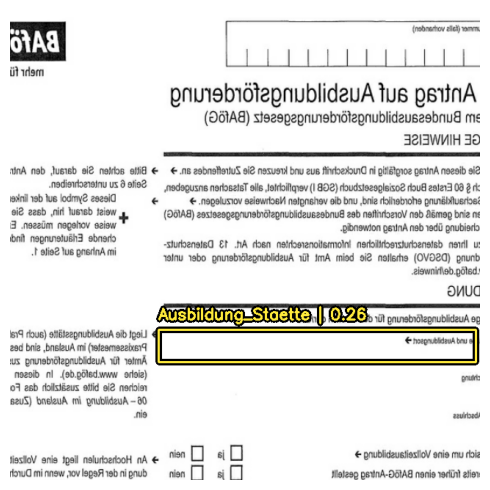

In [393]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        # y_true=y_true,
        y_pred=y_pred,
        scale=5,
        rows=1,
        cols=1,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )
   
visualize_detections(yolo_coco, dataset=train_ds, bounding_box_format="xyxy")

predict from a path

1/1 [==============================] - 11s 11s/step


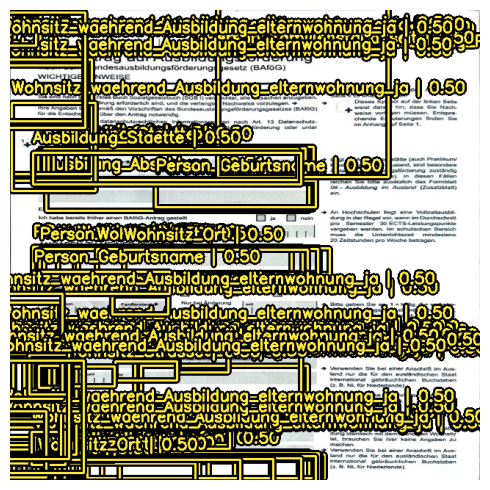

In [406]:
# Load and preprocess an example image (replace with your actual data loading code)
image_path = 'workspace/images/640x640/000000000003.jpeg'
image = tf.keras.utils.load_img(image_path)
image = tf.keras.utils.img_to_array(image)
image = tf.expand_dims(image, axis=0)  # Add batch dimension

# Make predictions
predictions = yolo_coco.predict(image)

predictions = bounding_box.to_ragged(predictions)
visualization.plot_bounding_box_gallery(
image,
value_range=(0, 255),
bounding_box_format='xyxy',
# y_true=y_true,
y_pred=predictions,
scale=5,
rows=1,
cols=1,
show=True,
font_scale=0.7,
class_mapping=class_mapping,
)



filter predicted data
save for every class only the best confidence

In [449]:
K=[]
i=0
f=[]
for row in predictions['classes'].values:
    j=0
    exsiting = False
    
    bb = predictions['boxes'].values.numpy()[i]
    
    xmin = bb[0]
    ymin = bb[1]
    xmax = bb[2]
    ymax = bb[3]
    
    w = xmax - xmin
    h = ymax - ymin
    A = w * h
    f.append(A)
    if A < 15428:

        for p in K:
            if p[1] == row.numpy():
                exsiting = True
                if p[2] < predictions['confidence'].values.numpy()[i]:
                    K[j][2] = predictions['confidence'].values.numpy()[i]
                    K[j][3] = predictions['boxes'].values.numpy()[i]
            j+=1
        
        if exsiting == False:
            K.append((i, row.numpy(), predictions['confidence'].values.numpy()[i], predictions['boxes'].values.numpy()[i] ))
     
    i+=1
f.sort()
print(f)

[1301.6368, 1317.1368, 1383.1127, 1411.9183, 1526.8313, 1541.8839, 1568.0715, 1602.569, 1627.1777, 1658.7465, 1724.4702, 1781.0336, 1783.4536, 1877.3202, 1982.0951, 1984.6962, 1997.7897, 2071.7158, 2082.0017, 2095.864, 2112.0684, 2120.9077, 2161.9348, 2220.5227, 2233.9412, 2261.3384, 2530.4177, 2584.7434, 2621.2786, 2697.8022, 2710.261, 2938.819, 3085.552, 3097.2036, 3807.037, 4217.666, 4746.534, 5539.1978, 5541.0225, 5718.3057, 6032.987, 6190.89, 6568.698, 6645.595, 6694.9395, 6844.034, 6892.671, 7301.0938, 7390.9307, 7738.9453, 7848.047, 8439.917, 8532.354, 8854.48, 9360.318, 9592.963, 9680.006, 9963.636, 10246.715, 10629.184, 10675.196, 10903.081, 10948.25, 11108.347, 11215.636, 11216.655, 11691.163, 11853.158, 12222.544, 12279.745, 12441.504, 12580.245, 12679.191, 12746.535, 12851.282, 13288.249, 13517.572, 13736.17, 13986.79, 14264.486, 14272.056, 14803.919, 14975.226, 15202.058, 15380.146, 15392.732, 15428.233, 15710.279, 15762.51, 15881.32, 16376.141, 17002.215, 18032.746, 19063

save the bbox, classes and confidence in np array

In [450]:
confidence = []
boxes = []
classes = []
for s in K:
    boxes.append(s[3])
    confidence.append(s[2])
    classes.append(s[1])
    

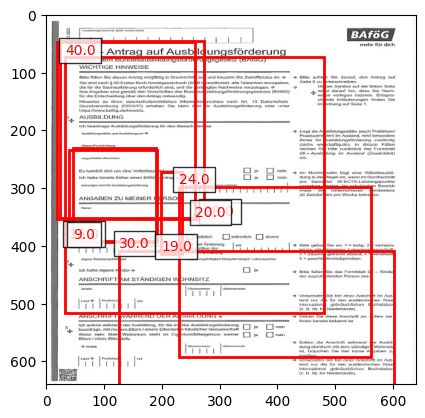

In [451]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

image_path = 'workspace/images/640x640/000000000010.jpeg'
# Bild laden
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots()

# Bild anzeigen
ax.imshow(image)

# Schleife über alle Bounding Boxes
for i, box in enumerate(boxes):
    xmin, xmax, ymin, ymax = box

    
    # Bounding Box hinzufügen
    rect = patches.Rectangle((xmin, ymin), xmax - xmin , ymax - ymin , linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
    # Klasse hinzufügen
    plt.text(xmin, ymin, classes[i], color='r', verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))

# Plot anzeigen
plt.show()

In [ ]:
# Load and preprocess an example image (replace with your actual data loading code)
image_path = 'workspace/images/original_name/scan_0001.jpg'
image = tf.keras.utils.load_img(image_path, target_size=(640, 640))
image = tf.keras.utils.img_to_array(image)
image = tf.expand_dims(image, axis=0)  # Add batch dimension



predictions = bounding_box.to_ragged(predictions)
visualization.plot_bounding_box_gallery(
image,
value_range=(0, 255),
bounding_box_format='xyxy',
# y_true=y_true,
y_pred=predictions,
scale=5,
rows=1,
cols=1,
show=True,
font_scale=0.7,
class_mapping=class_mapping,
)

1/1 [==============================] - 1s 598ms/step


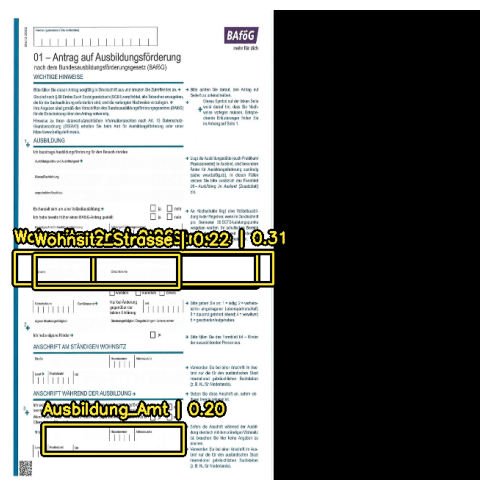

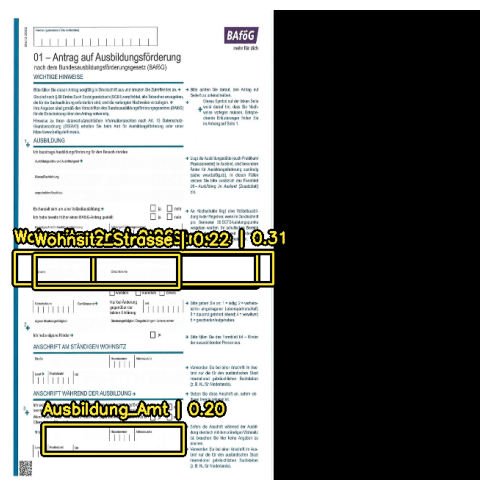

In [212]:
height=640
width=640
filepath= 'workspace/images/original_name/scan_0002.jpg'
image = [height, width, 3]
filepath
image = keras.utils.load_img(filepath)
image = np.array(image)

inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xyxy"
)
image_batch = inference_resizing([image])


y_pred = yolo.predict(image_batch)
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xyxy",
    class_mapping=class_mapping,
)

In [353]:
for example in train_ds.take(1):
    #print(example.keys())
    print("images shape:", example["images"].shape)
    print("bounding_boxes shape:", example["bounding_boxes"]["boxes"].shape)

TypeError: tuple indices must be integers or slices, not str